# Load libraries

In [1]:
%matplotlib inline

In [2]:
import fastai
fastai.show_install()



```text
=== Software === 
python version  : 3.7.0
fastai version  : 1.0.29.dev0
torch version   : 1.0.0.dev20181108
nvidia driver   : 396.54
torch cuda ver  : 9.2.148
torch cuda is   : available
torch cudnn ver : 7104
torch cudnn is  : enabled

=== Hardware === 
nvidia gpus     : 1
torch available : 1
  - gpu0        : 11178MB | GeForce GTX 1080 Ti

=== Environment === 
platform        : Linux-4.15.0-39-generic-x86_64-with-debian-buster-sid
distro          : Ubuntu 18.04 Bionic Beaver
conda env       : fastai-dev
python          : /home/cortex/anaconda3/envs/fastai-dev/bin/python
sys.path        : 
/home/cortex/workspace/research/tabularLearner/code
/home/cortex/anaconda3/envs/fastai-dev/lib/python37.zip
/home/cortex/anaconda3/envs/fastai-dev/lib/python3.7
/home/cortex/anaconda3/envs/fastai-dev/lib/python3.7/lib-dynload
/home/cortex/anaconda3/envs/fastai-dev/lib/python3.7/site-packages
/home/cortex/workspace/libs/fastai
/home/cortex/anaconda3/envs/fastai-dev/lib/python3.7/site-packag

In [3]:
from fastai import *
from fastai.tabular import *
from sklearn.model_selection import train_test_split, KFold

# Read in Data

In [4]:
path = Path('../data')

In [5]:
df = pd.read_csv('../data/adult.csv')

In [6]:
df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,>=50k
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,1
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,1
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,0


# Preprocessing

## Define column types

In [7]:
dep_var = '>=50k'
num_vars = ['age', 'fnlwgt', 'education-num']
cat_vars = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']

In [8]:
df = df.loc[:, num_vars+cat_vars+[dep_var]]

In [9]:
df.shape

(32561, 10)

# Model Definition

In [10]:
def selu_weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.5 / math.sqrt(m.weight.numel()))

    elif classname.find('Linear') != -1:
        size = m.weight.size()
        fan_out = size[0] # number of rows
        fan_in = size[1] # number of columns

        m.weight.data.normal_(0.0, 1.0 / math.sqrt(fan_in))
        # Estimated mean, must be around 0
        m.bias.data.fill_(0)

In [11]:
class MixupTabularModel(nn.Module):
    "Basic model for tabular data."

    def __init__(self, emb_szs:ListSizes, n_cont:int, out_sz:int, layers:Collection[int], ps:Collection[float]=None,
                 emb_drop:float=0., y_range:OptRange=None, use_bn:bool=True, bn_final:bool=False):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        self.embeds = nn.ModuleList([embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(emb_drop)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = self.get_sizes(layers, out_sz)
        actns = [nn.ReLU(inplace=True)] * (len(sizes)-2) + [None]
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers)

    def get_sizes(self, layers, out_sz):
        return [self.n_emb + self.n_cont] + layers + [out_sz]

    def forward(self, x_cat:Tensor, x_cont:Tensor) -> Tensor:
        if self.n_emb != 0:
            # x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            # x = torch.cat(x, 1)
            x = x_cat
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]
        return x

In [38]:
class TabularModel(nn.Module):
    "Basic model for tabular data."

    def __init__(self, emb_szs:ListSizes, n_cont:int, out_sz:int, layers:Collection[int], ps:Collection[float]=None,
                 emb_drop:float=0., y_range:OptRange=None, use_bn:bool=True, bn_final:bool=False, activation_type='relu',residual=False):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        self.embeds = nn.ModuleList([embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(emb_drop)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = self.get_sizes(layers, out_sz)
        if activation_type == 'relu':
            actns = [nn.ReLU(inplace=True)] * (len(sizes)-2) + [None]
        elif activation_type == 'selu':
            actns = [nn.SELU(inplace=True)] * (len(sizes)-2) + [None]
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers)
        if activation_type=='selu':
            for l in self.layers:
                if l.__class__.__name__ == 'Linear':
                    selu_weights_init(l)
        self.residual = residual
        if residual: self.res_lin=nn.Linear(self.n_emb+self.n_cont, sizes[-2])

    def get_sizes(self, layers, out_sz):
        return [self.n_emb + self.n_cont] + layers + [out_sz]

    def forward(self, x_cat:Tensor, x_cont:Tensor) -> Tensor:
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        if self.residual: x = self.layers[-1](self.res_lin(x) + self.layers[:-1](x))
        else: x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]
        return x

In [13]:
from fastai.callbacks.mixup import *

In [14]:
@dataclass
class TabularMixUpCallback(Callback):
    "Callback that creates the mixed-up input and target."
    learner:Learner
    alpha:float=0.4
    stack_x:bool=False
    stack_y:bool=True
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        last_cats, last_conts = last_input
        last_cats = torch.cat([e(last_cats[:,i]) for i,e in enumerate(self.learner.model.embeds)],1)
        if not train: return ([last_cats,last_conts], last_target) 
        lambd = np.random.beta(self.alpha, self.alpha, last_target.size(0))
        lambd = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
        lambd = last_conts.new(lambd)
        shuffle = torch.randperm(last_target.size(0)).to(last_conts.device)
        xcats1, xconts1, y1 = last_cats[shuffle], last_conts[shuffle], last_target[shuffle]
        if self.stack_x:
            # new_input = [last_input, last_input[shuffle], lambd]
            new_cats = [last_cats, last_cats[shuffle], lambd]
            new_conts = [last_conts, last_conts[shuffle], lambd]
        else: 
            # new_input = (last_input * lambd.view(lambd.size(0),1) + x1 * (1-lambd).view(lambd.size(0),1))
            new_cats = (last_cats * lambd.view(lambd.size(0),1) + xcats1 * (1-lambd).view(lambd.size(0),1))
            new_conts = (last_conts * lambd.view(lambd.size(0),1) + xconts1 * (1-lambd).view(lambd.size(0),1))
        if self.stack_y:
            new_target = torch.cat([last_target[:,None].float(), y1[:,None].float(), lambd[:,None].float()], 1)
        else:
            if len(last_target.shape) == 2:
                lambd = lambd.unsqueeze(1).float()
            new_target = last_target.float() * lambd + y1.float() * (1-lambd)
        return ([new_cats,new_conts], new_target) 

In [15]:
def tabular_learner(data, layers, emb_szs=None, metrics=None,
        ps=None, emb_drop=0., y_range=None, use_bn=True, mixup=False, activation_type='relu', residual=False, **kwargs):
    "Get a `Learner` using `data`, with `metrics`, including a `TabularModel` created using the remaining params."
    emb_szs = data.get_emb_szs(ifnone(emb_szs, {}))
    if mixup:
        model = MixupTabularModel(emb_szs, len(data.cont_names), out_sz=data.c, layers=layers, ps=ps, emb_drop=emb_drop,
                             y_range=y_range, use_bn=use_bn)
    else: 
        model = TabularModel(emb_szs, len(data.cont_names), out_sz=data.c, layers=layers, ps=ps, emb_drop=emb_drop,
                             y_range=y_range, use_bn=use_bn, activation_type=activation_type, residual=residual)
    l = Learner(data, model, metrics=metrics, **kwargs)
    if mixup: 
        l.loss_func = MixUpLoss(l.loss_func)
        l.callback_fns.append(partial(TabularMixUpCallback, alpha=0.4, stack_x=False, stack_y=True))
    return l

# One Cycle

In [35]:
bs=256

In [36]:
n_epochs=[5,10,20]

In [37]:
config = list(itertools.product(n_epochs))

In [38]:
procs = [FillMissing, Categorify, Normalize]

In [39]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [40]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [41]:
all_results = []
for j,param in enumerate(config):
    print(param)
    for i, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=bs))

        learn = tabular_learner(data, layers=[256]*3, metrics=accuracy)
        learn.fit_one_cycle(param[0], 1e-2)
        results = pd.DataFrame({
            'experiment': j+1,
            'fold': i+1, 'epochs':np.arange(1, len(learn.recorder.metrics)+1),
            'valid_loss': learn.recorder.val_losses,
            'metrics': [np.array(val[0]) for val in learn.recorder.metrics]})
        all_results.append(results)

Total time: 00:19
epoch  train_loss  valid_loss  accuracy
1      0.467539    0.372530    0.829545  (00:00)
2      0.379318    0.353762    0.836916  (00:01)
3      0.366330    0.361615    0.819103  (00:00)
4      0.361582    0.359054    0.825092  (00:00)
5      0.359535    0.368272    0.821714  (00:00)
6      0.358560    0.351907    0.837070  (00:01)
7      0.353264    0.357307    0.838759  (00:01)
8      0.350357    0.345165    0.836916  (00:01)
9      0.353888    0.353629    0.828471  (00:00)
10     0.349471    0.343271    0.842291  (00:00)
11     0.349509    0.345018    0.836302  (00:00)
12     0.345116    0.343668    0.841830  (00:00)
13     0.340240    0.348954    0.833538  (00:00)
14     0.344136    0.343908    0.837684  (00:00)
15     0.341608    0.344546    0.838606  (00:00)
16     0.333342    0.345934    0.838606  (00:01)
17     0.330186    0.347041    0.839681  (00:01)
18     0.329460    0.347212    0.838606  (00:00)
19     0.324417    0.349558    0.839681  (00:01)
20     0.32

In [42]:
all_results = pd.concat(all_results)

In [43]:
all_results.metrics = all_results.metrics.astype(np.float32)

In [44]:
tmp = (all_results.groupby(['experiment', 'epochs']).agg({'metrics':['mean', 'std'], 'valid_loss':['mean', 'std']}))

In [45]:
tmp.columns = [':'.join(col).strip() for col in tmp.columns.values]

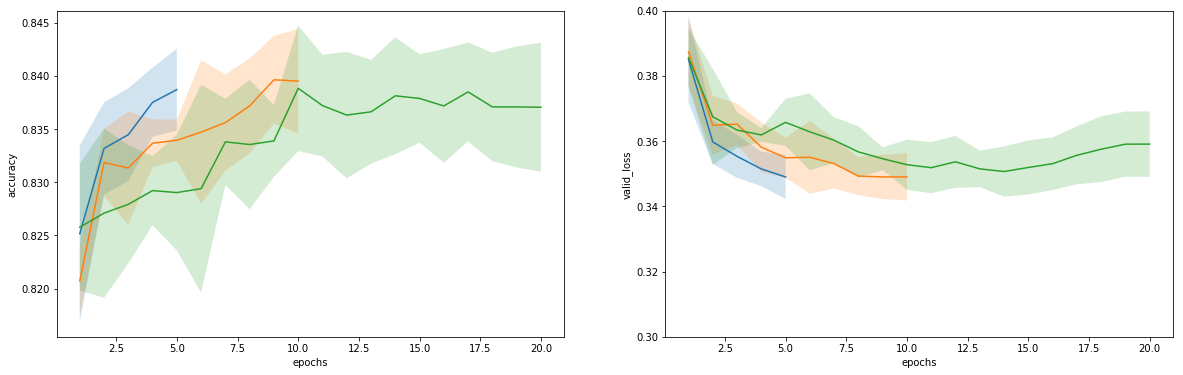

In [49]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
# plt.ylim(0.3, 0.4)
for _,exp in tmp.groupby('experiment'):
    epochs = exp.reset_index().epochs
    mu1 = exp.reset_index()['metrics:mean']
    errors1 = exp.reset_index()['metrics:std']
    mu2= exp.reset_index()['valid_loss:mean']
    errors2 = exp.reset_index()['valid_loss:std']
    
    
    ax[0].plot(epochs,mu1)
    ax[0].fill_between(epochs, mu1-errors1, mu1+errors1, alpha=0.2)
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epochs')
    ax[1].plot(epochs,mu2)
    ax[1].fill_between(epochs, mu2-errors2, mu2+errors2, alpha=0.2)
    ax[1].set_ylim(0.3,0.4)
    ax[1].set_ylabel('valid_loss')
    ax[1].set_xlabel('epochs')

In [ ]:
for j,param in enumerate(config):
    print(param)
    for i, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch())

        learn = tabular_learner(data, layers=[256]*3, metrics=accuracy)
        learn.fit(param[0], 1e-2)
        results = pd.DataFrame({
            'experiment': j+1+len(config),
            'fold': i+1, 'epochs':np.arange(1, len(learn.recorder.metrics)+1),
            'valid_loss': learn.recorder.val_losses,
            'metrics': [np.array(val[0]) for val in learn.recorder.metrics]})
        all_results.append(results)

[(5,), (10,), (20,)]


epoch,train_loss,valid_loss,accuracy
1,0.386080,0.367290,0.821281
2,0.369644,0.356294,0.834638
3,0.357398,0.352179,0.834792
4,0.361243,0.343058,0.841701


In [203]:
all_results.to_csv('layer_number_size_epoch3.csv', index=None)

# Number and Size of Layers

In [56]:
layer_sizes=[32,64,128,256,512,1024,2048]
layer_number=[1,2,4,8]

In [57]:
config = list(itertools.product(layer_sizes, layer_number))

In [58]:
procs = [FillMissing, Categorify, Normalize]

In [59]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [60]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [62]:
all_results = []
for j,param in enumerate(config):
    for i, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=bs))

        learn = tabular_learner(data, layers=[param[0]]*param[1], metrics=accuracy)
        learn.fit_one_cycle(3, 1e-2)
        results = pd.DataFrame({
            'experiment': j+1,
            'fold': i+1, 'epochs':np.arange(1, len(learn.recorder.metrics)+1),
            'valid_loss': learn.recorder.val_losses,
            'metrics': [np.array(val[0]) for val in learn.recorder.metrics]})
        all_results.append(results)

Total time: 00:07
epoch  train_loss  valid_loss  accuracy
1      0.431430    0.519626    0.741861  (00:02)
2      0.393890    0.366418    0.813268  (00:02)
3      0.358553    0.347780    0.838452  (00:02)



In [63]:
all_results = pd.concat(all_results)

In [67]:
all_results['metrics'] = all_results['metrics'].astype(np.float32)

In [68]:
all_results.to_csv('layer_number_size_epoch3.csv', index=None)

In [210]:
all_results = pd.read_csv('layer_number_size_epoch3.csv')

In [69]:
last_epoch_results = all_results.groupby(['experiment', 'fold']).tail(1)

In [70]:
avg_results = last_epoch_results.groupby('experiment').agg({'valid_loss': ['mean','std'],
                                              'metrics': ['mean','std']})

In [71]:
avg_results.columns = [':'.join(col).strip() for col in avg_results.columns.values]

In [72]:
avg_results.reset_index(inplace=True)

In [73]:
avg_results = avg_results.join(pd.DataFrame(config, columns=['size', 'number']))

In [74]:
avg_results.head(5)

,experiment,valid_loss:mean,valid_loss:std,metrics:mean,metrics:std,size,number
0,1,0.350554,0.006468,0.837259,0.004297,32,1
1,2,0.349625,0.006108,0.837658,0.003450,32,2
2,3,0.349711,0.005581,0.837659,0.003312,32,4
3,4,0.351230,0.005836,0.835816,0.005128,32,8
4,5,0.349504,0.005480,0.838303,0.002911,64,1


In [80]:
plot_df = avg_results.pivot_table(index='size', columns='number', values='metrics:mean')

In [81]:
errors = avg_results.pivot_table(index='size', columns='number', values='metrics:std')

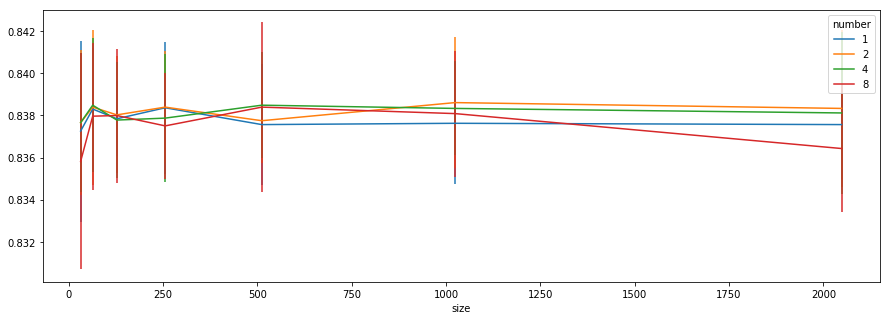

In [82]:
plot_df.plot(yerr=errors, figsize=(15,5))
# plt.fill_between(plot_df.index, plot_df+errors, plot_df-errors)
# plt.ylim(0.34,0.36)

In [83]:
import seaborn as sns

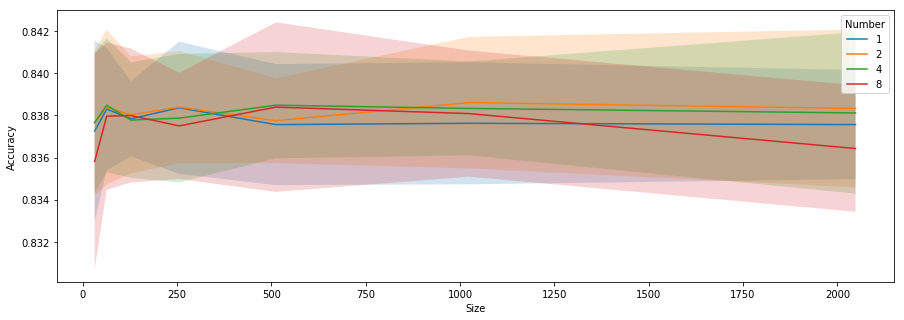

In [84]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xlabel('Size')
ax.set_ylabel('Accuracy')
clrs = sns.color_palette("husl", plot_df.shape[1])
for i in range(plot_df.shape[1]):
    mu = plot_df.iloc[:,i]
    sig = errors.iloc[:,i]
    ax.plot(mu, label=plot_df.columns[i])
    ax.fill_between(plot_df.index.values, mu-sig, mu+sig, alpha=0.2)
ax.legend(title='Number')

# Dropout

In [ ]:
bs=64

In [85]:
layer_sizes=[128,1024]
dropout = np.arange(0, 0.99, 0.1)

In [86]:
config = list(itertools.product(layer_sizes, dropout))

In [87]:
procs = [FillMissing, Categorify, Normalize]

In [88]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [89]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [90]:
all_results = []
for j,param in enumerate(config):
    print(param)
    for i, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=bs))

        learn = tabular_learner(data, layers=[param[0]]*3, ps=[param[1]]*3, metrics=accuracy)
        learn.fit_one_cycle(5, 1e-2)
        results = pd.DataFrame({
            'experiment': j+1,
            'fold': i+1, 'epochs':np.arange(1, len(learn.recorder.metrics)+1),
            'valid_loss': learn.recorder.val_losses,
            'metrics': [np.array(val[0]) for val in learn.recorder.metrics]})
        all_results.append(results)

Total time: 00:13
epoch  train_loss  valid_loss  accuracy
1      0.644507    0.400259    0.828010  (00:02)
2      0.489409    0.363193    0.833538  (00:02)
3      0.449815    0.360703    0.834306  (00:02)
4      0.403977    0.355740    0.835074  (00:02)
5      0.384971    0.353026    0.835381  (00:02)



In [91]:
all_results = pd.concat(all_results)

In [110]:
all_results['metrics']=all_results['metrics'].astype(np.float32)

In [114]:
all_results.to_csv('size_dropout.csv', index=None)

In [115]:
mean_df = (all_results.groupby(['experiment', 'fold']).tail(1).groupby('experiment').agg({'metrics':'mean'}).reset_index()
 .join(pd.DataFrame(config,columns=['size', 'dropout']))
 .pivot(index='dropout', columns='size', values='metrics'))
std_df = (all_results.groupby(['experiment', 'fold']).tail(1).groupby('experiment').agg({'metrics':'std'}).reset_index()
 .join(pd.DataFrame(config,columns=['size', 'dropout']))
 .pivot(index='dropout', columns='size', values='metrics'))

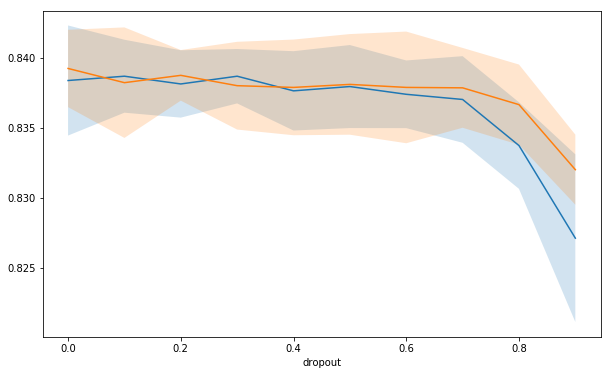

In [120]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('dropout')
for i in range(mean_df.shape[1]):
    dp = mean_df.index
    mu = mean_df.iloc[:,i]
    sig = std_df.iloc[:,i]
    ax.plot(dp, mu)
    ax.fill_between(dp, mu-sig, mu+sig,alpha=0.2)

# Embedding Sizes

# Feature Scalings

# Sample Size

In [349]:
sample_sizes = [1000,2000,4000,8000,16000,32000]

In [350]:
config = list(itertools.product(sample_sizes))

In [351]:
procs = [FillMissing, Categorify, Normalize]

In [352]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [357]:
all_results = []
for j,param in enumerate(config):
    print(param)
    df_sub = df.sample(param[0], random_state=42).copy().reset_index(drop=True)
    src = TabularList.from_df(df_sub, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)
    for i, (train_ids, valid_ids) in enumerate(kf.split(df_sub)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch())
        learn = tabular_learner(data, layers=[256]*2, metrics=accuracy)
        learn.fit_one_cycle(5, 1e-2)
        results = pd.DataFrame({
            'experiment': j+1,
            'fold': i+1, 'epochs':np.arange(1, len(learn.recorder.metrics)+1),
            'valid_loss': learn.recorder.val_losses,
            'metrics': [np.array(val[0]) for val in learn.recorder.metrics]})
        all_results.append(results)

Total time: 00:49
epoch  train_loss  valid_loss  accuracy
1      0.367863    0.386474    0.833281  (00:10)
2      0.374710    0.372234    0.830156  (00:09)
3      0.361934    0.366826    0.832656  (00:10)
4      0.347930    0.360920    0.833750  (00:09)
5      0.339000    0.359601    0.833125  (00:09)



In [358]:
all_results = pd.concat(all_results)

In [375]:
tmp = all_results.groupby(['experiment', 'epochs']).agg({'valid_loss':['mean', 'std']})
tmp.columns = [':'.join(col).strip() for col in tmp.columns.values]
tmp.reset_index(inplace=True)
mean_df = tmp.pivot(index='epochs', columns='experiment', values='valid_loss:mean')
sig_df = tmp.pivot(index='epochs', columns='experiment', values='valid_loss:std')

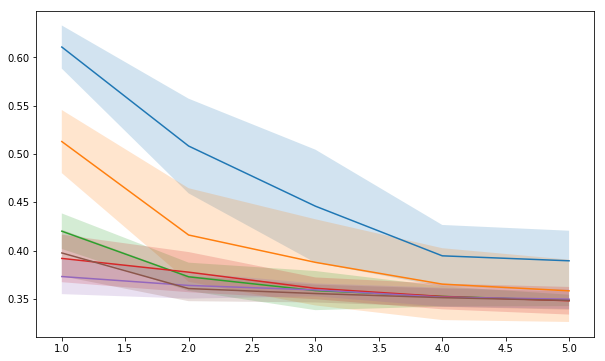

In [379]:
fig, ax = plt.subplots(figsize=(10,6))
# plt.ylim(0.34,0.36)
for i in range(mean_df.shape[1]):
    mu = mean_df.iloc[:,i]
    sig = sig_df.iloc[:,i]
    epochs = mean_df.index.values
    ax.plot(epochs, mu)
    ax.fill_between(epochs, mu-sig, mu+sig, alpha=0.2)

In [203]:
all_results.to_csv('layer_number_dropout_epoch3.csv', index=None)

# Architecture Shape

# SeLU

In [581]:
bs=1024

In [582]:
activation_params = ['relu', 'selu']

In [583]:
config = list(itertools.product(activation_params))

In [584]:
procs = [FillMissing, Categorify, Normalize]

In [585]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [586]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [587]:
all_results = []
for j,param in enumerate(config):
    print(param)
    for i, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=bs))
        if param[0]=='selu': use_bn=False
        else: use_bn=True
        learn = tabular_learner(data, layers=[128]*8, metrics=accuracy, activation_type=param[0], use_bn=use_bn)
        learn.fit_one_cycle(10, 1e-2)
        results = pd.DataFrame({
            'experiment': j+1,
            'fold': i+1, 'epochs':np.arange(1, len(learn.recorder.metrics)+1),
            'valid_loss': learn.recorder.val_losses,
            'metrics': [np.array(val[0]) for val in learn.recorder.metrics]})
        all_results.append(results)

Total time: 00:08
epoch  train_loss  valid_loss  accuracy
1      0.463162    0.421649    0.795455  (00:00)
2      0.413181    0.393706    0.798372  (00:00)
3      0.778326    0.589560    0.680897  (00:00)
4      0.633642    0.373670    0.826321  (00:00)
5      0.514186    0.350487    0.837070  (00:00)
6      0.445731    0.347424    0.838452  (00:00)
7      0.406773    0.347359    0.837224  (00:00)
8      0.382678    0.346356    0.843520  (00:00)
9      0.368886    0.345387    0.841370  (00:00)
10     0.360331    0.345278    0.840909  (00:00)



In [588]:
all_results = pd.concat(all_results)
all_results['metrics']=all_results['metrics'].astype(np.float32)

In [589]:
tmp = (all_results.groupby(['experiment', 'epochs']).agg({'metrics':['mean', 'std'], 'valid_loss':['mean', 'std']}))

In [590]:
tmp.columns = [':'.join(col).strip() for col in tmp.columns.values]

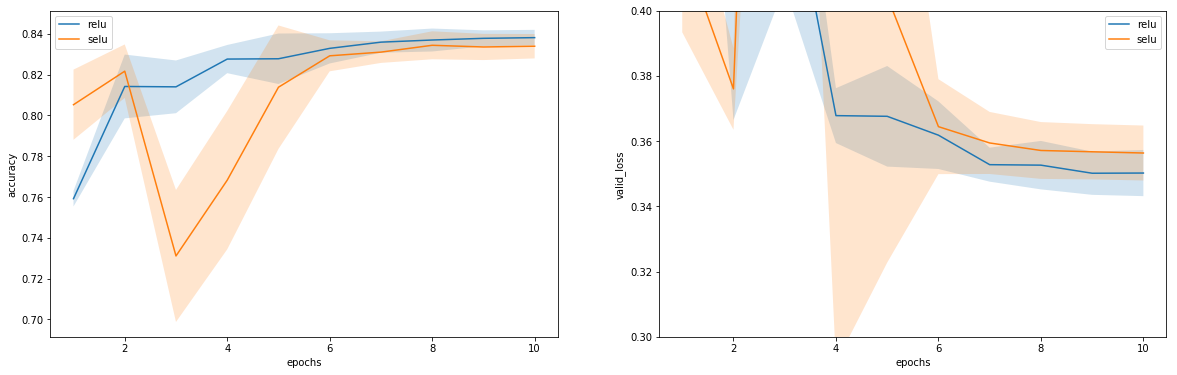

In [591]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
# plt.ylim(0.3, 0.4)
for nm,exp in tmp.groupby('experiment'):
    epochs = exp.reset_index().epochs
    mu1 = exp.reset_index()['metrics:mean']
    errors1 = exp.reset_index()['metrics:std']
    mu2= exp.reset_index()['valid_loss:mean']
    errors2 = exp.reset_index()['valid_loss:std']
    
    
    ax[0].plot(epochs,mu1, label=activation_params[nm-1])
    ax[0].fill_between(epochs, mu1-errors1, mu1+errors1, alpha=0.2)
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epochs')
    ax[1].plot(epochs,mu2,label=activation_params[nm-1])
    ax[1].fill_between(epochs, mu2-errors2, mu2+errors2, alpha=0.2)
    ax[1].set_ylim(0.3,0.4)
    ax[1].set_ylabel('valid_loss')
    ax[1].set_xlabel('epochs')
ax[0].legend()
ax[1].legend()

# Residual Connections

In [61]:
bs=1024

In [62]:
res_params = [False, True]

In [63]:
config = list(itertools.product(res_params))

In [64]:
procs = [FillMissing, Categorify, Normalize]

In [65]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [66]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [ ]:
all_results = []
for j,param in enumerate(config):
    print(param)
    for i, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=bs))
        learn = tabular_learner(data, layers=[256]*5, metrics=accuracy, residual=param[0])
        learn.fit_one_cycle(10, 1e-2)
        results = pd.DataFrame({
            'experiment': j+1,
            'fold': i+1, 'epochs':np.arange(1, len(learn.recorder.metrics)+1),
            'valid_loss': learn.recorder.val_losses,
            'metrics': [np.array(val[0]) for val in learn.recorder.metrics]})
        all_results.append(results)

(False,)


epoch,train_loss,valid_loss,accuracy
1,0.556845,0.556914,0.761247


In [56]:
all_results = pd.concat(all_results)
all_results['metrics']=all_results['metrics'].astype(np.float32)

In [57]:
tmp = (all_results.groupby(['experiment', 'epochs']).agg({'metrics':['mean', 'std'], 'valid_loss':['mean', 'std']}))

In [58]:
tmp.columns = [':'.join(col).strip() for col in tmp.columns.values]

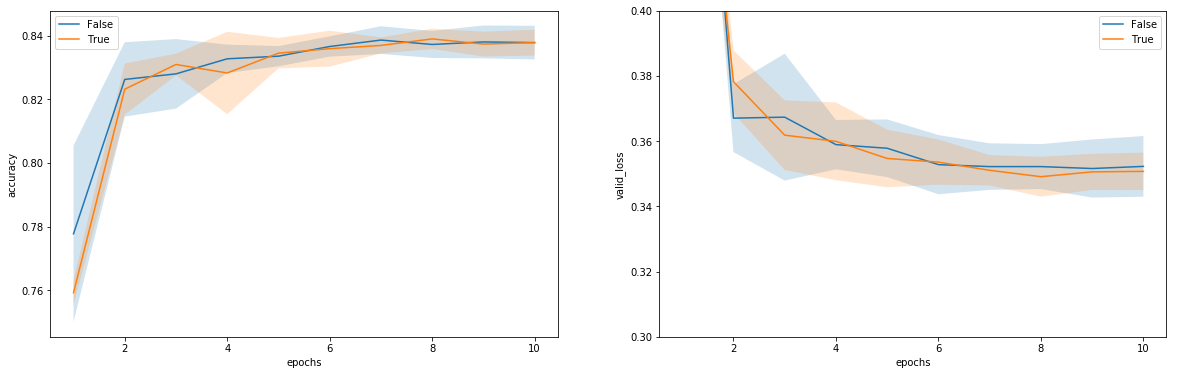

In [60]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
# plt.ylim(0.3, 0.4)
for nm,exp in tmp.groupby('experiment'):
    epochs = exp.reset_index().epochs
    mu1 = exp.reset_index()['metrics:mean']
    errors1 = exp.reset_index()['metrics:std']
    mu2= exp.reset_index()['valid_loss:mean']
    errors2 = exp.reset_index()['valid_loss:std']
    
    
    ax[0].plot(epochs,mu1, label=res_params[nm-1])
    ax[0].fill_between(epochs, mu1-errors1, mu1+errors1, alpha=0.2)
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epochs')
    ax[1].plot(epochs,mu2,label=res_params[nm-1])
    ax[1].fill_between(epochs, mu2-errors2, mu2+errors2, alpha=0.2)
    ax[1].set_ylim(0.3,0.4)
    ax[1].set_ylabel('valid_loss')
    ax[1].set_xlabel('epochs')
ax[0].legend()
ax[1].legend()

# Attention

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

# Augmentation Strategies

In [458]:
bs=1024

In [459]:
mixup_param = [False, True]

In [460]:
config = list(itertools.product(mixup_param))

In [461]:
procs = [FillMissing, Categorify, Normalize]

In [462]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [463]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [464]:
all_results = []
for j,param in enumerate(config):
    print(param)
    for i, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=bs))
        learn = tabular_learner(data, layers=[2048]*2, metrics=accuracy, mixup=param[0])
        learn.fit_one_cycle(10, 1e-2)
        results = pd.DataFrame({
            'experiment': j+1,
            'fold': i+1, 'epochs':np.arange(1, len(learn.recorder.metrics)+1),
            'valid_loss': learn.recorder.val_losses,
            'metrics': [np.array(val[0]) for val in learn.recorder.metrics]})
        all_results.append(results)

Total time: 00:08
epoch  train_loss  valid_loss  accuracy
1      0.681056    0.530435    0.766892  (00:00)
2      0.536760    0.407806    0.816646  (00:00)
3      0.491277    0.462490    0.765971  (00:00)
4      0.466968    0.359751    0.835534  (00:00)
5      0.449771    0.351057    0.837991  (00:00)
6      0.439718    0.349233    0.838145  (00:00)
7      0.434246    0.362175    0.835534  (00:00)
8      0.429932    0.362239    0.838759  (00:00)
9      0.426001    0.354755    0.840756  (00:00)
10     0.422759    0.350808    0.842138  (00:00)



In [465]:
all_results = pd.concat(all_results)
all_results['metrics']=all_results['metrics'].astype(np.float32)

In [466]:
tmp = (all_results.groupby(['experiment', 'epochs']).agg({'metrics':['mean', 'std'], 'valid_loss':['mean', 'std']}))

In [467]:
tmp.columns = [':'.join(col).strip() for col in tmp.columns.values]

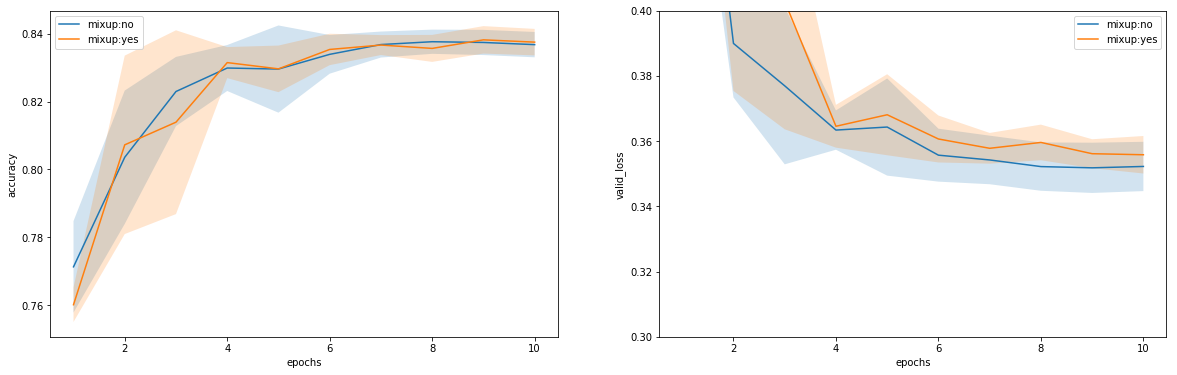

In [468]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
# plt.ylim(0.3, 0.4)
for nm,exp in tmp.groupby('experiment'):
    epochs = exp.reset_index().epochs
    mu1 = exp.reset_index()['metrics:mean']
    errors1 = exp.reset_index()['metrics:std']
    mu2= exp.reset_index()['valid_loss:mean']
    errors2 = exp.reset_index()['valid_loss:std']
    
    
    ax[0].plot(epochs,mu1, label=['mixup:no', 'mixup:yes'][nm-1])
    ax[0].fill_between(epochs, mu1-errors1, mu1+errors1, alpha=0.2)
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epochs')
    ax[1].plot(epochs,mu2,label=['mixup:no', 'mixup:yes'][nm-1])
    ax[1].fill_between(epochs, mu2-errors2, mu2+errors2, alpha=0.2)
    ax[1].set_ylim(0.3,0.4)
    ax[1].set_ylabel('valid_loss')
    ax[1].set_xlabel('epochs')
ax[0].legend()
ax[1].legend()

# Pretraining

## Process categoricals

**Note**: missing values are not yet treated

In [12]:
categories={}
for col in cat_vars:
    train_df.loc[:, col] = train_df.loc[:, col].astype('category').cat.as_ordered()
    categories.update({col:train_df.loc[:, col].cat.categories.values})
    test_df.loc[:, col] = pd.Categorical(test_df.loc[:, col], categories=categories[col], ordered=True)

still need to choose how to represent them, either one-hot or integer encoded

One-hot encode

In [13]:
for col in cat_vars:
    train_df = train_df.drop(columns=col).join(pd.get_dummies(train_df.loc[:,col], prefix=col))
    test_df = test_df.drop(columns=col).join(pd.get_dummies(test_df.loc[:,col], prefix=col))

In [14]:
train_df.head()

,age,fnlwgt,>=50k,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White
0,45,167523,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,44,126199,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,55,37438,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,34,143766,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,46,167159,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Process numerics

In [15]:
for col in num_vars:
    train_df.loc[:, col] = train_df[col].astype(np.float32)
    test_df.loc[:, col] = test_df[col].astype(np.float32)

### Choose normalisation

Standard 0 mean and unit variance scaling

In [16]:
stats={}
for col in num_vars:
    stats.update({col: np.array([train_df[col].mean(), train_df[col].std()])})
    train_df.loc[:,col] = (train_df[col]-stats[col][0])/stats[col][1]
    test_df.loc[:,col] = (test_df[col]-stats[col][0])/stats[col][1]

In [17]:
stats

{'age': array([38.588524, 13.686339]),
 'fnlwgt': array([189604.40625 , 104962.476562])}

## Dataset

In [18]:
class TabularDataset(Dataset):
    def __init__(self, df, dep_var):
        self.x = df.drop(columns=dep_var).values
        self.y = df[dep_var].values
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = self.get_x(idx)
        y = self.get_x(idx)
        return (x, y)
    
    def get_x(self, idx):
        return torch.tensor(self.x[idx,:], dtype=torch.float32)
    
    def get_y(self, idx):
        return torch.tensor(self.y[idx], dtype=torch.int64)

In [19]:
train_ds = TabularDataset(train_df, dep_var)
test_ds = TabularDataset(test_df, dep_var)

## Data loader

In [20]:
bs=64

In [21]:
train_dl = DataLoader(train_ds, batch_size=bs)
test_dl = DataLoader(test_ds, batch_size=bs)

In [22]:
x, y = next(iter(train_dl))

In [24]:
print(x.shape, y.shape)

torch.Size([64, 60]) torch.Size([64, 60])


In [25]:
data = DataBunch(train_dl, test_dl)

# Model

In [95]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        sizes = [60, 200, 200, 2]
        actns = [nn.ReLU(inplace=True)] * (len(sizes)-2) + [None]
        layers = []
        for i,(n_in,n_out,act) in enumerate(zip(sizes[:-1],sizes[1:],actns)):
            layers += bn_drop_lin(n_in, n_out, bn=False, p=0, actn=act)
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [43]:
class DAE(nn.Module):
    def __init__(self):
        super().__init__()
        sizes = [60, 200, 200, 60]
        actns = [nn.ReLU(inplace=True)] * (len(sizes)-2) + [None]
        layers = []
        for i,(n_in,n_out,act) in enumerate(zip(sizes[:-1],sizes[1:],actns)):
            layers += bn_drop_lin(n_in, n_out, bn=False, p=0, actn=act)
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [44]:
m = DAE()

In [45]:
m

DAE(
  (layers): Sequential(
    (0): Linear(in_features=60, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=200, out_features=60, bias=True)
  )
)

In [46]:
x_batch, y_batch = next(iter(train_dl))

In [47]:
m(x_batch).shape

torch.Size([64, 60])

In [48]:
learn = Learner(data, m, metrics=None, loss_func=F.mse_loss)

In [49]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


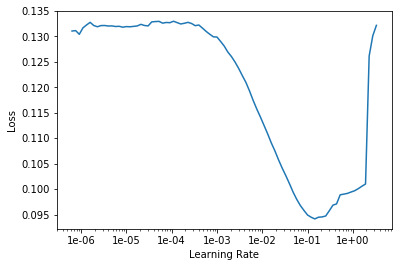

In [50]:
learn.recorder.plot()

In [51]:
learn.fit_one_cycle(3, 1e-2)

Total time: 00:10
epoch  train_loss  valid_loss
1      0.003137    0.003181    (00:03)
2      0.000648    0.000430    (00:03)
3      0.000052    0.000055    (00:03)



In [52]:
m.eval()

DAE(
  (layers): Sequential(
    (0): Linear(in_features=60, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=200, out_features=60, bias=True)
  )
)

In [53]:
m(x_batch)

tensor([[ 0.4682, -0.2084, -0.0009,  ..., -0.0007,  0.0003,  0.9998],
        [ 0.3922, -0.5888,  0.0005,  ...,  0.0012,  0.0048,  0.9942],
        [ 1.1826, -1.4442,  0.0016,  ..., -0.0002, -0.0019,  1.0065],
        ...,
        [-0.4199, -0.6836, -0.0034,  ..., -0.0032,  0.0053,  0.9925],
        [ 0.2455, -0.8040,  0.0040,  ..., -0.0051, -0.0063,  1.0067],
        [-0.1169, -1.1652, -0.0095,  ..., -0.0034, -0.0037,  1.0045]],
       grad_fn=<ThAddmmBackward>)

In [54]:
x_batch

tensor([[ 0.4685, -0.2104,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.3954, -0.6041,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 1.1991, -1.4497,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [-0.4083, -0.6732,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.2493, -0.8124,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [-0.1161, -1.1711,  0.0000,  ...,  0.0000,  0.0000,  1.0000]])

In [84]:
learn.fit(10, 0.01)

Total time: 00:25
epoch  train_loss  valid_loss
1      0.347521    0.344244    (00:02)
2      0.343011    0.344807    (00:02)
3      0.341174    0.347008    (00:02)
4      0.337883    0.347670    (00:02)
5      0.333931    0.351055    (00:02)
6      0.332627    0.355039    (00:02)
7      0.327785    0.360182    (00:02)
8      0.326168    0.354243    (00:02)
9      0.324182    0.356167    (00:02)
10     0.318789    0.365484    (00:02)

